In [1]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from google.colab import drive
import json
import shutil

# **Data Loading**

In [2]:
# Memuat data
from google.colab import files
files.upload()

Saving data_balita.csv to data_balita.csv


{'data_balita.csv': b'Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi\n0,laki-laki,44.5919732943438,stunted\n0,laki-laki,56.7052033668847,tinggi\n0,laki-laki,46.8633575967919,normal\n0,laki-laki,47.5080256315438,normal\n0,laki-laki,42.7434938911793,severely stunted\n0,laki-laki,44.2577186391463,stunted\n0,laki-laki,59.5725227366786,tinggi\n0,laki-laki,42.7017961514634,severely stunted\n0,laki-laki,45.2517789938352,stunted\n0,laki-laki,57.201961037402,tinggi\n0,laki-laki,51.3538576645907,normal\n0,laki-laki,53.0499109874484,normal\n0,laki-laki,43.5448720454205,severely stunted\n0,laki-laki,46.2526320256362,normal\n0,laki-laki,43.6760350399285,severely stunted\n0,laki-laki,52.6397050139326,normal\n0,laki-laki,46.8869974730066,normal\n0,laki-laki,57.4223187955893,tinggi\n0,laki-laki,49.748323964378,normal\n0,laki-laki,42.0181075624513,severely stunted\n0,laki-laki,45.9674598956419,stunted\n0,laki-laki,56.4878694570832,tinggi\n0,laki-laki,57.0525336232187,tinggi\n0,laki-laki,57.88

In [3]:
# Memuat data
from google.colab import files
files.upload()

Saving data_menu_mpasi.csv to data_menu_mpasi.csv


{'data_menu_mpasi.csv': b'Kode Menu,Kombinasi Menu,Kode Umur,Kode Frekuensi,calories_kcal,fats_g,sod_mg,carb_g,fiber_g,sugar_g,protein_g,vitA_g,calcium_mg,thiamin_mg,zinc_mg,potassium_mg,magnesium_mg,vitE_mg,vitK_mcg,vitC_mg,vitB6_mg,copper_mg,carotene_mg,carotene_mcg,cryptoxanthin_mcg,lycopene_mcg,cholesterol_mg\nM11,"Bubur beras, ayam, bayam",B1,F1,180.0,6.0,90.0,25.0,2.5,3.5,7.5,0.14,70.0,0.09,1.0,280.0,28.0,0.9,18.0,9.0,0.25,0.09,180.0,180.0,40.0,0.0,25.0\nM12,"Bubur kentang, hati ayam, wortel",B1,F1,180.0,6.0,90.0,25.0,2.5,3.5,7.5,0.14,70.0,0.09,1.0,280.0,28.0,0.9,18.0,9.0,0.25,0.09,180.0,180.0,40.0,0.0,25.0\nM13,"Nasi tim halus, ikan, labu siam",B1,F1,180.0,6.0,90.0,25.0,2.5,3.5,7.5,0.14,70.0,0.09,1.0,280.0,28.0,0.9,18.0,9.0,0.25,0.09,180.0,180.0,40.0,0.0,25.0\nM14,"Bubur beras merah, tahu, brokoli",B1,F1,180.0,6.0,90.0,25.0,2.5,3.5,7.5,0.14,70.0,0.09,1.0,280.0,28.0,0.9,18.0,9.0,0.25,0.09,180.0,180.0,40.0,0.0,25.0\nM15,"Bubur kacang hijau, pisang",B1,F1,180.0,6.0,90.0,25.0,2.5,3.

In [4]:
# Load Data
child_data = pd.read_csv('/content/data_balita.csv')
food_data = pd.read_csv('/content/data_menu_mpasi.csv')

# **Data Understanding**

**data_balita.csv**

In [5]:
# Menampilkan dataset balita teratas
child_data.head()

Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi
0             0     laki-laki          44.591973           stunted
1             0     laki-laki          56.705203            tinggi
2             0     laki-laki          46.863358            normal
3             0     laki-laki          47.508026            normal
4             0     laki-laki          42.743494  severely stunted

In [6]:
# Menampilkan jumlah row dan column (ukuran shape) dataset balita
child_data.shape

(120999, 4)

In [7]:
# Menampilkan informasi mengenai dataset balita
child_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [8]:
# Memeriksa missing value pada dataset balita
child_data.isnull().sum()

Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64

In [9]:
# Memeriksa data duplikat pada dataset balita
child_duplicate = child_data.duplicated().sum()
print(f"Jumlah baris duplikat: {child_duplicate}")

Jumlah baris duplikat: 81574


In [10]:
# Menampilkan statistik deskriptif dari dataset balita untuk kolom numerik
child_data.describe()

Umur (bulan)  Tinggi Badan (cm)
count  120999.000000      120999.000000
mean       30.173803          88.655434
std        17.575119          17.300997
min         0.000000          40.010437
25%        15.000000          77.000000
50%        30.000000          89.800000
75%        45.000000         101.200000
max        60.000000         128.000000

# **data_menu_mpasi.csv**

Kode Umur meliputi:
- B1 => 6-8 bulan
- B2 => 9-11 bulan
- B3 => 12-24 bulan
- B4 => 25-60 bulan

Kode Frekuensi meliputi:
- F1 => 2 kali makanan utama
- F2 => 3 kali makanan utama
- F3 => 3 kali makanan utama & 1 kali makanan snack
- F4 => 3 kali makanan utama & 2 kali makanan snack

In [11]:
# Menampilkan dataset food nutrition teratas
food_data.head()

Kode Menu                    Kombinasi Menu Kode Umur Kode Frekuensi  \
0       M11          Bubur beras, ayam, bayam        B1             F1   
1       M12  Bubur kentang, hati ayam, wortel        B1             F1   
2       M13   Nasi tim halus, ikan, labu siam        B1             F1   
3       M14  Bubur beras merah, tahu, brokoli        B1             F1   
4       M15        Bubur kacang hijau, pisang        B1             F1   

   calories_kcal  fats_g  sod_mg  carb_g  fiber_g  sugar_g  ...  vitE_mg  \
0          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
1          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
2          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
3          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
4          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   

   vitK_mcg  vitC_mg  vitB6_mg  copper_mg  carotene_mg  carotene_mcg  \
0      18.0      9.0      0.25       0.09        180.0         180.0   
1      18.0      9.0      0.25       0.09        180.0         180.0   
2      18.0      9.0      0.25       0.09        180.0         180.0   
3      18.0      9.0      0.25       0.09        180.0         180.0   
4      18.0      9.0      0.25       0.09        180.0         180.0   

   cryptoxanthin_mcg  lycopene_mcg  cholesterol_mg  
0               40.0           0.0            25.0  
1               40.0           0.0            25.0  
2               40.0           0.0            25.0  
3               40.0           0.0            25.0  
4               40.0           0.0            25.0  

[5 rows x 27 columns]

Terlihat bahwa data tersusun secara terstruktur sehingga perlu dilakukan shuffle (pengacakan) pada row data untuk menghindari bias urutan saat training (model bisa jadi overfitting pada pola urutan, bukan pada fitur sebenarnya). Dan juga agar distribusi label lebih merata per batch sehingga bisa membantu konvergensi yang lebih stabil dan cepat dalam training.

In [12]:
# Acak baris (shuffle)
food_shuffled = food_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Simpan kembali
# df_shuffled.to_csv("menu_mpasi_shuffled.csv", index=False)

In [13]:
food_shuffled.head()

Kode Menu                        Kombinasi Menu Kode Umur Kode Frekuensi  \
0      M128  Nasi, daging giling, tumis labu siam        B4             F4   
1       M30         Nasi tim lembut, telur, tomat        B1             F1   
2       M93       Pasta, daging ayam, sayur kukus        B3             F3   
3      M108     Nasi, daging, wortel kukus, jeruk        B3             F3   
4       M67                 Jagung, tempe, buncis        B2             F2   

   calories_kcal  fats_g  sod_mg  carb_g  fiber_g  sugar_g  ...  vitE_mg  \
0          270.0    10.0   130.0    38.0      4.0      5.5  ...      1.6   
1          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
2          250.0     9.0   120.0    35.0      3.5      5.0  ...      1.5   
3          250.0     9.0   120.0    35.0      3.5      5.0  ...      1.5   
4          220.0     7.0   110.0    30.0      3.0      4.0  ...      1.2   

   vitK_mcg  vitC_mg  vitB6_mg  copper_mg  carotene_mg  carotene_mcg  \
0      35.0     16.0      0.42       0.13        270.0         270.0   
1      18.0      9.0      0.25       0.09        180.0         180.0   
2      30.0     15.0      0.40       0.12        250.0         250.0   
3      30.0     15.0      0.40       0.12        250.0         250.0   
4      25.0     12.0      0.35       0.10        220.0         220.0   

   cryptoxanthin_mcg  lycopene_mcg  cholesterol_mg  
0               90.0          60.0            45.0  
1               40.0           0.0            25.0  
2               80.0          50.0            40.0  
3               80.0          50.0            40.0  
4               60.0           0.0            35.0  

[5 rows x 27 columns]

Terlihat bahwa hasil outputnya menunjukkan data sudah teracak.

In [14]:
# Menampilkan jumlah row dan column (ukuran shape) dataset food nutrition
food_shuffled.shape

(144, 27)

In [15]:
# Menampilkan informasi mengenai dataset food nutrition
food_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Kode Menu          144 non-null    object 
 1   Kombinasi Menu     144 non-null    object 
 2   Kode Umur          144 non-null    object 
 3   Kode Frekuensi     144 non-null    object 
 4   calories_kcal      144 non-null    float64
 5   fats_g             144 non-null    float64
 6   sod_mg             144 non-null    float64
 7   carb_g             144 non-null    float64
 8   fiber_g            144 non-null    float64
 9   sugar_g            144 non-null    float64
 10  protein_g          144 non-null    float64
 11  vitA_g             144 non-null    float64
 12  calcium_mg         144 non-null    float64
 13  thiamin_mg         144 non-null    float64
 14  zinc_mg            144 non-null    float64
 15  potassium_mg       144 non-null    float64
 16  magnesium_mg       144 non

In [16]:
# Memeriksa missing value pada dataset food nutrition
food_shuffled.isnull().sum()

Kode Menu            0
Kombinasi Menu       0
Kode Umur            0
Kode Frekuensi       0
calories_kcal        0
fats_g               0
sod_mg               0
carb_g               0
fiber_g              0
sugar_g              0
protein_g            0
vitA_g               0
calcium_mg           0
thiamin_mg           0
zinc_mg              0
potassium_mg         0
magnesium_mg         0
vitE_mg              0
vitK_mcg             0
vitC_mg              0
vitB6_mg             0
copper_mg            0
carotene_mg          0
carotene_mcg         0
cryptoxanthin_mcg    0
lycopene_mcg         0
cholesterol_mg       0
dtype: int64

In [17]:
# Memeriksa data duplikat pada dataset food nutrition
food_duplicate = food_shuffled.duplicated().sum()
print(f"Jumlah baris duplikat: {food_duplicate}")

Jumlah baris duplikat: 0


In [18]:
# Menampilkan statistik deskriptif dari dataset food nutrition untuk kolom numerik
food_shuffled.describe()

calories_kcal      fats_g      sod_mg      carb_g     fiber_g  \
count     144.000000  144.000000  144.000000  144.000000  144.000000   
mean      220.115347    7.534097  106.383403   30.950208    3.073194   
std        51.122342    2.338205   27.380813    6.790774    0.871942   
min        19.200000    0.170000    4.110000    3.500000    0.000000   
25%       180.000000    6.000000   90.000000   25.000000    2.500000   
50%       220.000000    7.000000  110.000000   30.000000    3.000000   
75%       250.000000    9.000000  120.000000   35.000000    3.500000   
max       270.000000   10.000000  130.000000   39.840000    4.000000   

          sugar_g   protein_g      vitA_g  calcium_mg  thiamin_mg  ...  \
count  144.000000  144.000000  144.000000  144.000000  144.000000  ...   
mean     4.413889    8.866528    1.790069   92.613889    0.136111  ...   
std      1.368476    2.287224    7.712134   24.160884    0.108770  ...   
min      0.000000    0.530000    0.000000    7.540000    0.090000  ...   
25%      3.500000    7.500000    0.180000   70.000000    0.100000  ...   
50%      4.000000    9.000000    0.200000   95.000000    0.120000  ...   
75%      5.000000   10.000000    0.220000  110.000000    0.140000  ...   
max     14.540000   11.000000   53.500000  261.520000    0.930000  ...   

          vitE_mg    vitK_mcg     vitC_mg    vitB6_mg   copper_mg  \
count  144.000000  144.000000  144.000000  144.000000  144.000000   
mean     1.228056   25.203264   13.262986    0.342500    0.107292   
std      0.389628    9.076578    6.677467    0.089603    0.021096   
min      0.000000    0.000000    0.120000    0.010000    0.020000   
25%      0.900000   18.000000    9.000000    0.250000    0.090000   
50%      1.200000   25.000000   13.010000    0.350000    0.100000   
75%      1.500000   30.000000   15.250000    0.400000    0.120000   
max      1.600000   35.000000   73.630000    0.540000    0.140000   

       carotene_mg  carotene_mcg  cryptoxanthin_mcg  lycopene_mcg  \
count   144.000000    144.000000         144.000000    144.000000   
mean    214.749375    214.385208          63.262222     25.902778   
std      65.826225     66.964784          24.671707     27.694972   
min       0.000000      0.000000           0.000000      0.000000   
25%     180.000000    180.000000          40.000000      0.000000   
50%     220.000000    220.000000          60.000000      0.000000   
75%     250.000000    250.000000          80.000000     50.000000   
max     270.000000    270.000000          90.000000     60.000000   

       cholesterol_mg  
count      144.000000  
mean        33.828056  
std         11.560087  
min          0.000000  
25%         25.000000  
50%         35.000000  
75%         40.000000  
max         45.000000  

[8 rows x 23 columns]

# **Exploratory Data Analysis (EDA)**

**data_balita.csv**

In [19]:
# Melakukan Mapping pada kolom kategorikal untuk memudahkan dalam melihat korelasi antar fitur
child_data['Label_kelamin'] = child_data['Jenis Kelamin'].map({'laki-laki': 0, 'perempuan': 1})
child_data['Label_Gizi'] = child_data['Status Gizi'].map({'severely stunted': 0, 'stunted': 1, 'normal': 2, 'tinggi': 3})
child_data

Umur (bulan) Jenis Kelamin  Tinggi Badan (cm)       Status Gizi  \
0                  0     laki-laki          44.591973           stunted   
1                  0     laki-laki          56.705203            tinggi   
2                  0     laki-laki          46.863358            normal   
3                  0     laki-laki          47.508026            normal   
4                  0     laki-laki          42.743494  severely stunted   
...              ...           ...                ...               ...   
120994            60     perempuan         100.600000            normal   
120995            60     perempuan          98.300000           stunted   
120996            60     perempuan         121.300000            normal   
120997            60     perempuan         112.200000            normal   
120998            60     perempuan         109.800000            normal   

        Label_kelamin  Label_Gizi  
0                   0           1  
1                   0           3  
2                   0           2  
3                   0           2  
4                   0           0  
...               ...         ...  
120994              1           2  
120995              1           1  
120996              1           2  
120997              1           2  
120998              1           2  

[120999 rows x 6 columns]

<ipython-input-20-1847167483>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=jenis_kelamin.index, y=jenis_kelamin.values, palette="pastel")


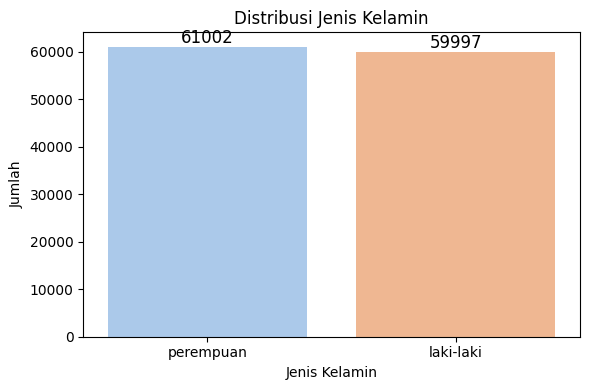

In [20]:
# Distribusi Jenis Kelamin pada dataset balita
jenis_kelamin = child_data['Jenis Kelamin'].value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=jenis_kelamin.index, y=jenis_kelamin.values, palette="pastel")

for i, value in enumerate(jenis_kelamin.values):
    ax.text(i, value + 0.05, str(value), ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

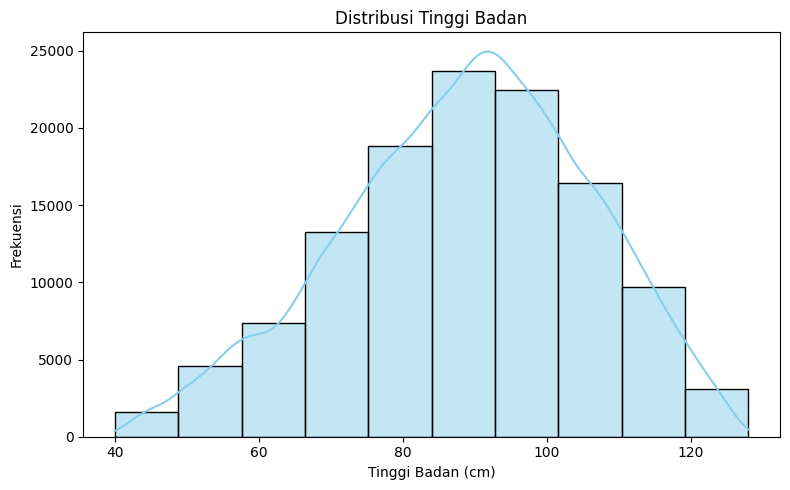

In [21]:
# Distribusi Tinggi Badan Balita
plt.figure(figsize=(8, 5))
sns.histplot(child_data['Tinggi Badan (cm)'], kde=True, bins=10, color='skyblue')
plt.title('Distribusi Tinggi Badan')
plt.xlabel('Tinggi Badan (cm)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

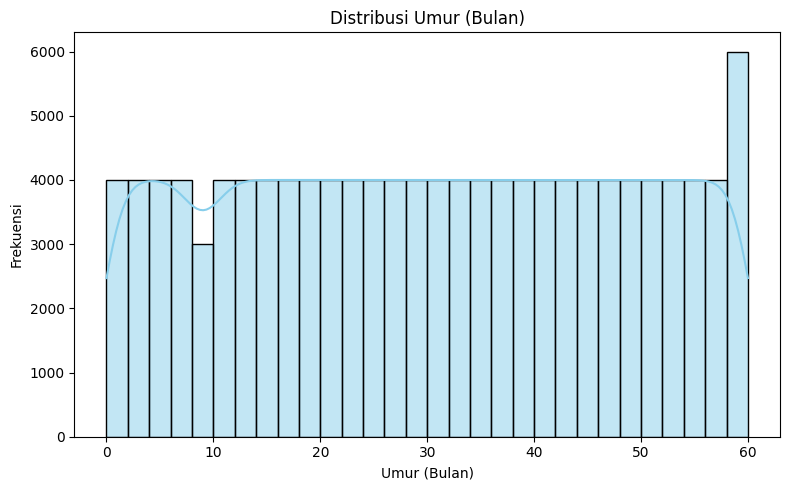

In [22]:
# Distribusi Umur Balita
plt.figure(figsize=(8, 5))
sns.histplot(child_data['Umur (bulan)'], kde=True, bins=30, color='skyblue')
plt.title('Distribusi Umur (Bulan)')
plt.xlabel('Umur (Bulan)')
plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

<ipython-input-23-330917512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Status Gizi', data = child_data, palette='Set2')


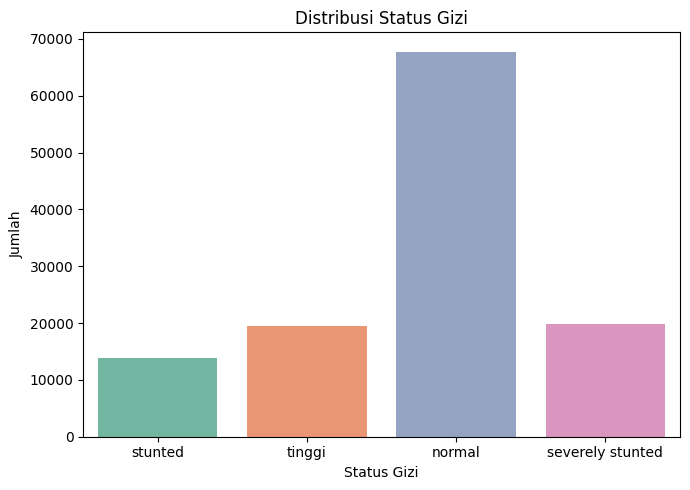

In [23]:
# Distribusi status gizi balita
plt.figure(figsize=(7, 5))
sns.countplot(x='Status Gizi', data = child_data, palette='Set2')
plt.title('Distribusi Status Gizi')
plt.xlabel('Status Gizi')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

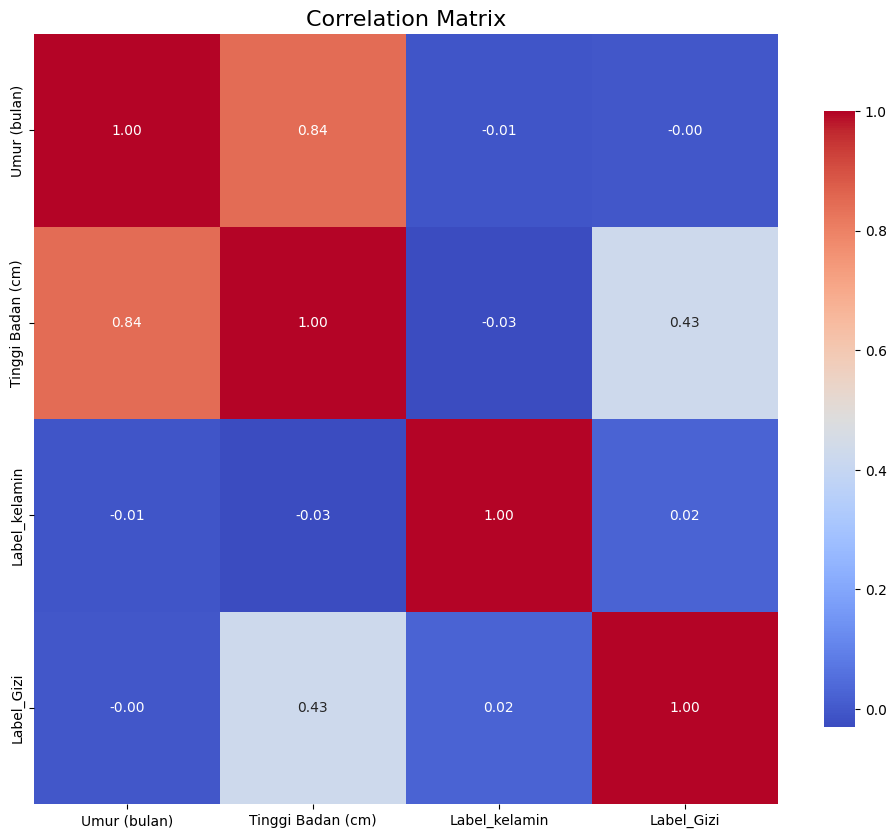

In [24]:
# Hubungan antar fitur menggunakan table correlation matrix
numerical_features = child_data.select_dtypes(include=np.number)

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8}, annot_kws={'size': 10})
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Terlihat bahwa label kelamin menunjukkan korelasi yang sangat lemah dengan fitur lainnya sehingga dapat dilakukan dropping untuk tahap selanjutnya. Begitu pula dengan kolom 'Jenis Kelamin' yang secara langsung juga mencerminkan isi dari kolom 'Label_Kelamin'.

**data_menu_mpasi.csv**

<ipython-input-25-4113090588>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


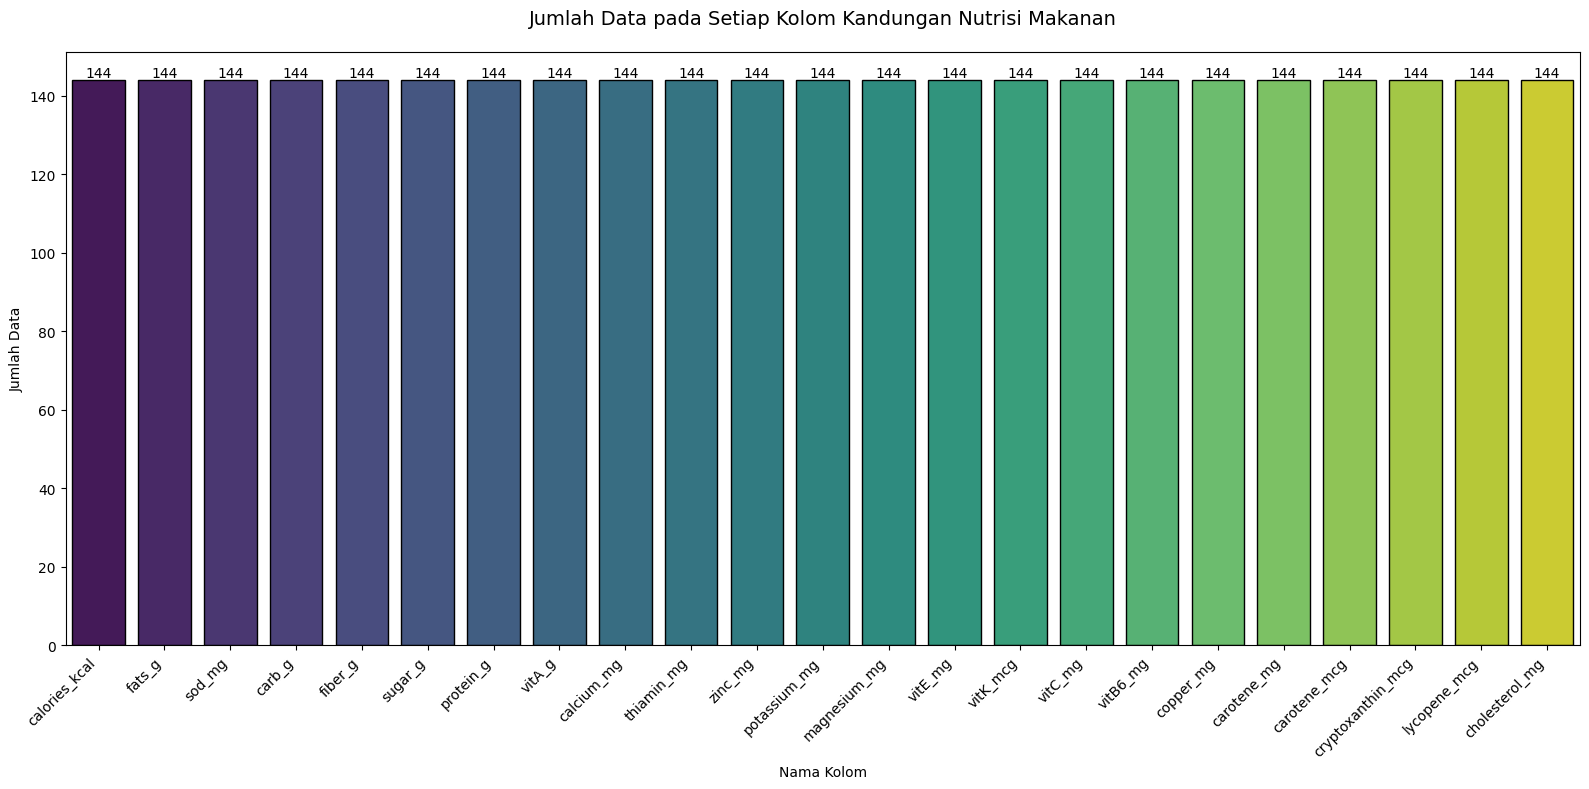

In [25]:
# Pilih hanya kolom nutrisi makanan dimana terlihat bertipe numerik
nutrition_columns = food_shuffled.select_dtypes(include=['float', 'int'])

# Hitung jumlah data non-null per kolom
count_data = nutrition_columns.count().reset_index()
count_data.columns = ['Kolom', 'Jumlah Data']

# 3. Buat Bar Plot
plt.figure(figsize=(16, 8))
sns.barplot(
    x='Kolom',
    y='Jumlah Data',
    data=count_data,
    palette='viridis',  # Warna
    edgecolor='black'
)

# 4. Tambahkan Judul dan Label
plt.title('Jumlah Data pada Setiap Kolom Kandungan Nutrisi Makanan', fontsize=14, pad=20)
plt.xlabel('Nama Kolom')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45, ha='right')  # Rotasi label kolom agar tidak tumpang tindih

# 5. Tambahkan nilai di atas setiap bar
for index, value in enumerate(count_data['Jumlah Data']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

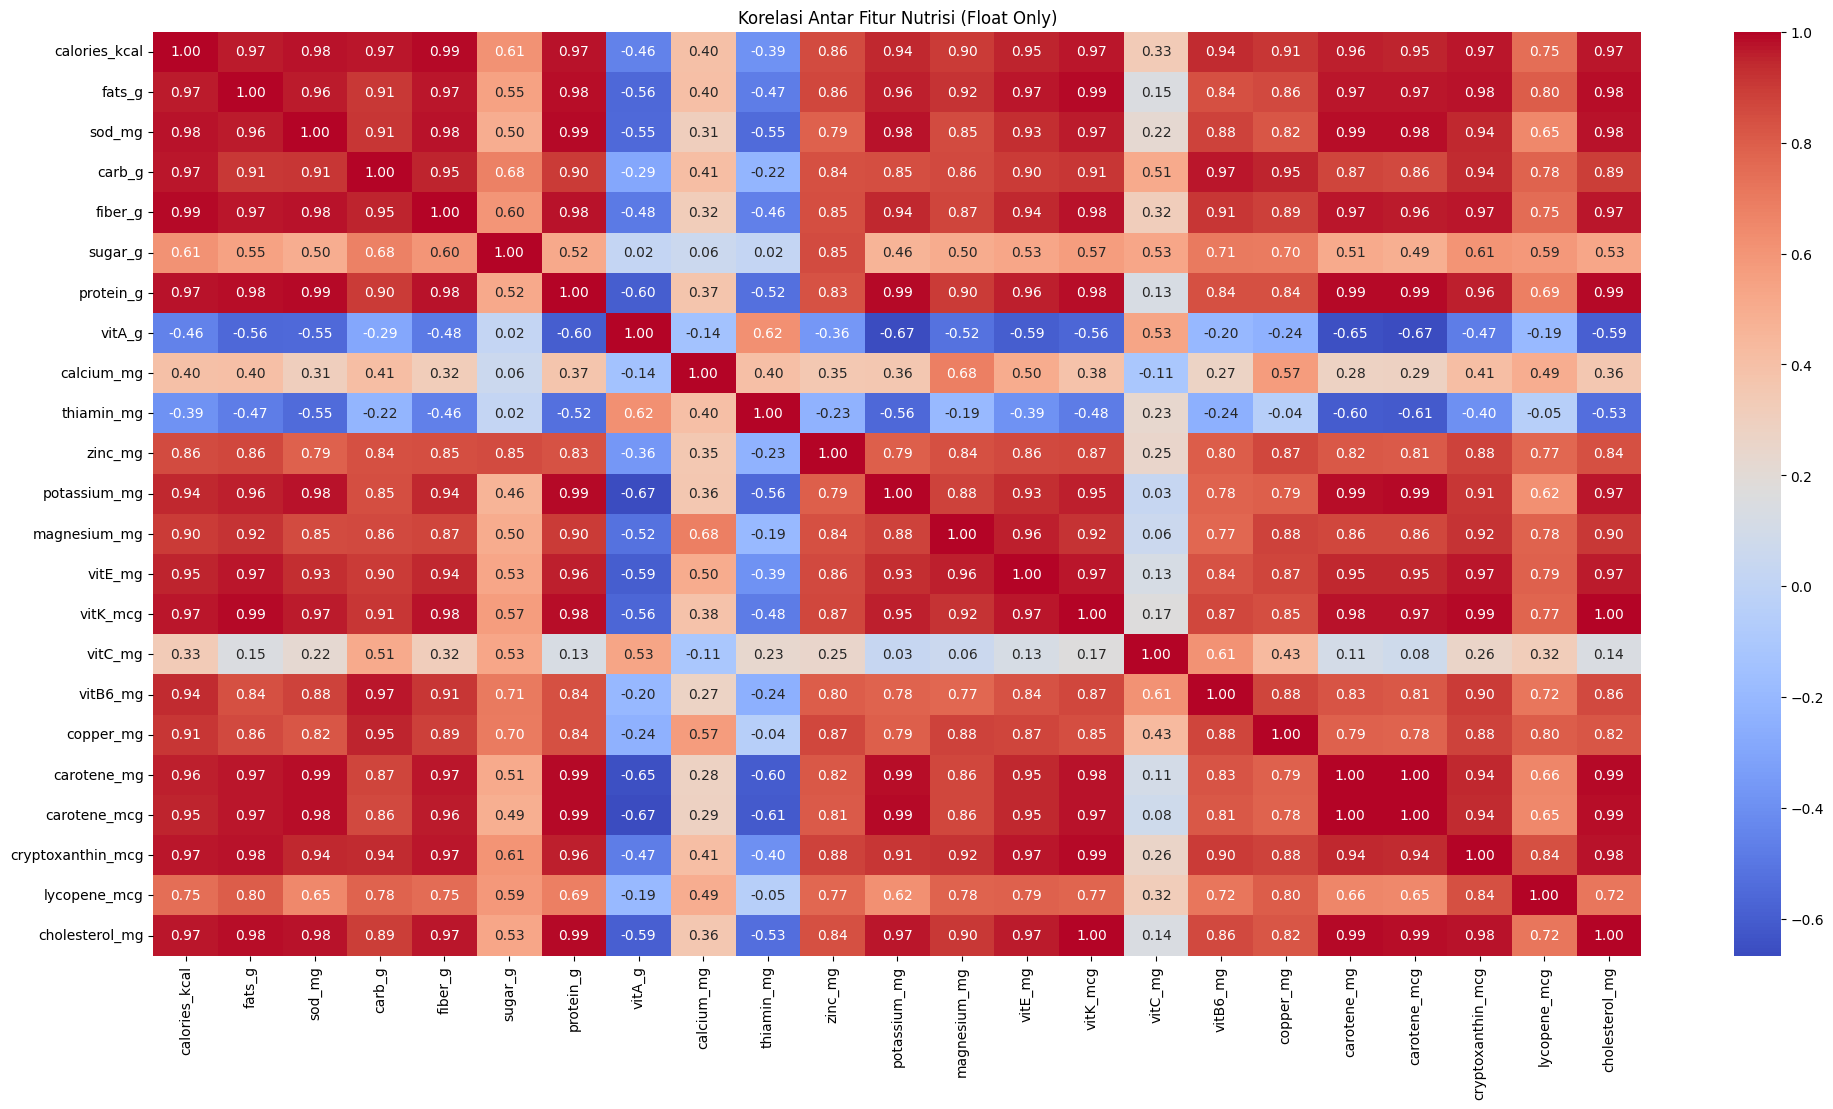

In [26]:
# Memilih hanya kolom dengan tipe data float (kolom nutrisi)
float_data = food_shuffled.select_dtypes(include=['int','float'])

# Korelasi antar fitur dengan tipe data float
corr_matrix = float_data.corr()

# Visualisasi korelasi
plt.figure(figsize=(24, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Korelasi Antar Fitur Nutrisi (Float Only)')
plt.show()

Terlihat bahwa semua fitur ingredients makanan menunjukkan mayoritas antar fitur memiliki korelasi yang kuat ditunjukkan dengan tanda warna merah pada tabel.

# **Data Preprocessing**

**data_balita.csv**

In [27]:
# Drop kolom yang tidak diperlukan pada dataset balita
child_data.drop(['Jenis Kelamin'], inplace=True, axis=1)
child_data.drop(['Label_kelamin'], inplace=True, axis=1)
child_data

Umur (bulan)  Tinggi Badan (cm)       Status Gizi  Label_Gizi
0                  0          44.591973           stunted           1
1                  0          56.705203            tinggi           3
2                  0          46.863358            normal           2
3                  0          47.508026            normal           2
4                  0          42.743494  severely stunted           0
...              ...                ...               ...         ...
120994            60         100.600000            normal           2
120995            60          98.300000           stunted           1
120996            60         121.300000            normal           2
120997            60         112.200000            normal           2
120998            60         109.800000            normal           2

[120999 rows x 4 columns]

In [28]:
# Drop data duplikat
child_duplicate = child_data.drop_duplicates()
print(f' Data duplikat: {child_duplicate.duplicated().sum()}')
child_duplicate.info()

 Data duplikat: 0
<class 'pandas.core.frame.DataFrame'>
Index: 26000 entries, 0 to 120972
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Umur (bulan)       26000 non-null  int64  
 1   Tinggi Badan (cm)  26000 non-null  float64
 2   Status Gizi        26000 non-null  object 
 3   Label_Gizi         26000 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1015.6+ KB


Terlihat data duplikat berhasil ditangani, dilakukan dropping karena jumlah dataset tergolong besar sehingga meskipun dilakukan dropping tidak akan terlalu berpengaruh untuk analisa lebih lanjut. Dan terlihat setelah dilakukan dropping, jumlah data tetap terhitung besar.

In [29]:
# Memeriksa kembali data duplikat pada dataset balita
child_df = child_duplicate.duplicated().sum()
print(f"Jumlah baris duplikat: {child_df}")

Jumlah baris duplikat: 0


In [30]:
# Mengembalikan dataframe dari child_duplicate menjadi child_data
child_data = child_duplicate

In [31]:
# Melakukan normalisasi data pada dataset balita
# Fitur yang Digunakan
child_features = ['Umur (bulan)', 'Tinggi Badan (cm)']

scaler_child = MinMaxScaler()
normalize_child_feature = scaler_child.fit_transform(child_data[child_features])

In [32]:
child_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26000 entries, 0 to 120972
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Umur (bulan)       26000 non-null  int64  
 1   Tinggi Badan (cm)  26000 non-null  float64
 2   Status Gizi        26000 non-null  object 
 3   Label_Gizi         26000 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1015.6+ KB


In [33]:
# Mapping kolom 'Umur (bulan) menjadi kolom 'kode umur'
def map_kode_umur(umur):
  if 0 <= umur <= 5:
    return 'B0'
  elif 6 <= umur <= 8:
    return 'B1'
  elif 9 <= umur <= 11:
    return 'B2'
  elif 12 <= umur <= 24:
    return 'B3'
  elif 25 <= umur <= 60:
    return 'B4'
  return None

child_data['Kode Umur'] = child_data['Umur (bulan)'].apply(map_kode_umur)

<ipython-input-33-2287935419>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_data['Kode Umur'] = child_data['Umur (bulan)'].apply(map_kode_umur)


In [34]:
child_data.head()

Umur (bulan)  Tinggi Badan (cm)       Status Gizi  Label_Gizi Kode Umur
0             0          44.591973           stunted           1        B0
1             0          56.705203            tinggi           3        B0
2             0          46.863358            normal           2        B0
3             0          47.508026            normal           2        B0
4             0          42.743494  severely stunted           0        B0

Terlihat setelah dilakukan SMOTE (The Synthetic Minority Over-Sampling Technique), data pada tiap kelasnya menjadi seimbang.

**data_menu_mpasi.csv**

In [35]:
food_shuffled.head()

Kode Menu                        Kombinasi Menu Kode Umur Kode Frekuensi  \
0      M128  Nasi, daging giling, tumis labu siam        B4             F4   
1       M30         Nasi tim lembut, telur, tomat        B1             F1   
2       M93       Pasta, daging ayam, sayur kukus        B3             F3   
3      M108     Nasi, daging, wortel kukus, jeruk        B3             F3   
4       M67                 Jagung, tempe, buncis        B2             F2   

   calories_kcal  fats_g  sod_mg  carb_g  fiber_g  sugar_g  ...  vitE_mg  \
0          270.0    10.0   130.0    38.0      4.0      5.5  ...      1.6   
1          180.0     6.0    90.0    25.0      2.5      3.5  ...      0.9   
2          250.0     9.0   120.0    35.0      3.5      5.0  ...      1.5   
3          250.0     9.0   120.0    35.0      3.5      5.0  ...      1.5   
4          220.0     7.0   110.0    30.0      3.0      4.0  ...      1.2   

   vitK_mcg  vitC_mg  vitB6_mg  copper_mg  carotene_mg  carotene_mcg  \
0      35.0     16.0      0.42       0.13        270.0         270.0   
1      18.0      9.0      0.25       0.09        180.0         180.0   
2      30.0     15.0      0.40       0.12        250.0         250.0   
3      30.0     15.0      0.40       0.12        250.0         250.0   
4      25.0     12.0      0.35       0.10        220.0         220.0   

   cryptoxanthin_mcg  lycopene_mcg  cholesterol_mg  
0               90.0          60.0            45.0  
1               40.0           0.0            25.0  
2               80.0          50.0            40.0  
3               80.0          50.0            40.0  
4               60.0           0.0            35.0  

[5 rows x 27 columns]

In [36]:
# Normalisasi fitur yang menunjukkan nutrisi makanan/ingredienst menggunakan MinMaxScaler
nutrient_cols = ['calories_kcal', 'fats_g', 'sod_mg', 'carb_g', 'fiber_g', 'sugar_g',
                 'protein_g', 'vitA_g', 'calcium_mg', 'thiamin_mg', 'zinc_mg',
                 'potassium_mg', 'magnesium_mg', 'vitE_mg', 'vitK_mcg', 'vitC_mg',
                 'vitB6_mg', 'copper_mg', 'carotene_mg', 'carotene_mcg',
                 'cryptoxanthin_mcg', 'lycopene_mcg', 'cholesterol_mg']

scaler = MinMaxScaler()
food_shuffled[nutrient_cols] = scaler.fit_transform(food_shuffled[nutrient_cols])


In [37]:
# filter sebelum merge agar menghindari join many to many
filtered_menu = food_shuffled[food_shuffled['Kode Umur'].isin(child_data['Kode Umur'].unique())]

In [38]:
# Merging data untuk menggabungkan data balita dan data menu mpasi
merged_df = pd.merge(child_data, filtered_menu, on='Kode Umur', how='inner')
merged_df

Umur (bulan)  Tinggi Badan (cm) Status Gizi  Label_Gizi Kode Umur  \
0                  6               79.0      tinggi           3        B1   
1                  6               79.0      tinggi           3        B1   
2                  6               79.0      tinggi           3        B1   
3                  6               79.0      tinggi           3        B1   
4                  6               79.0      tinggi           3        B1   
...              ...                ...         ...         ...       ...   
638685            60              127.6      tinggi           3        B4   
638686            60              127.6      tinggi           3        B4   
638687            60              127.6      tinggi           3        B4   
638688            60              127.6      tinggi           3        B4   
638689            60              127.6      tinggi           3        B4   

       Kode Menu                       Kombinasi Menu Kode Frekuensi  \
0            M30        Nasi tim lembut, telur, tomat             F1   
1            M23     Bubur kacang merah, tempe, bayam             F1   
2            M29        Tim kentang, hati ayam, bayam             F1   
3            M38           Bubur jagung, ayam, wortel             F1   
4            M22      Pure wortel, hati ayam, kentang             F1   
...          ...                                  ...            ...   
638685      M114     Spaghetti, daging, tomat, pisang             F4   
638686      M127       Mie, ayam, wortel rebus, jeruk             F4   
638687      M132         Nasi, tahu, sop jagung, apel             F4   
638688      M117  Roti, telur orak-arik, tomat, jeruk             F4   
638689      M113       Nasi, ikan, sayur lodeh, jeruk             F4   

        calories_kcal    fats_g  ...  vitE_mg  vitK_mcg   vitC_mg  vitB6_mg  \
0            0.641148  0.593082  ...   0.5625  0.514286  0.120800  0.452830   
1            0.641148  0.593082  ...   0.5625  0.514286  0.120800  0.452830   
2            0.641148  0.593082  ...   0.5625  0.514286  0.120800  0.452830   
3            0.641148  0.593082  ...   0.5625  0.514286  0.120800  0.452830   
4            0.641148  0.593082  ...   0.5625  0.514286  0.120800  0.452830   
...               ...       ...  ...      ...       ...       ...       ...   
638685       1.000000  1.000000  ...   1.0000  1.000000  0.216025  0.773585   
638686       1.000000  1.000000  ...   1.0000  1.000000  0.216025  0.773585   
638687       1.000000  1.000000  ...   1.0000  1.000000  0.216025  0.773585   
638688       1.000000  1.000000  ...   1.0000  1.000000  0.216025  0.773585   
638689       1.000000  1.000000  ...   1.0000  1.000000  0.216025  0.773585   

        copper_mg  carotene_mg  carotene_mcg  cryptoxanthin_mcg  lycopene_mcg  \
0        0.583333     0.666667      0.666667           0.444444           0.0   
1        0.583333     0.666667      0.666667           0.444444           0.0   
2        0.583333     0.666667      0.666667           0.444444           0.0   
3        0.583333     0.666667      0.666667           0.444444           0.0   
4        0.583333     0.666667      0.666667           0.444444           0.0   
...           ...          ...           ...                ...           ...   
638685   0.916667     1.000000      1.000000           1.000000           1.0   
638686   0.916667     1.000000      1.000000           1.000000           1.0   
638687   0.916667     1.000000      1.000000           1.000000           1.0   
638688   0.916667     1.000000      1.000000           1.000000           1.0   
638689   0.916667     1.000000      1.000000           1.000000           1.0   

        cholesterol_mg  
0             0.555556  
1             0.555556  
2             0.555556  
3             0.555556  
4             0.555556  
...                ...  
638685        1.000000  
638686        1.000000  
638687        1.000000  
638688        1.000000  
638689        1.00000

Untuk mengontrol jumlah data hasil merged sebelumnya, lakukan kombinasi data untuk mengontrol jumlah data dimana akan dengan menggabungkan setiap Balita dengan N Menu yang Sesuai Umur (Sampling Menu per Anak)

In [39]:
# Buat list hasil akhir
samples = []

for _, child in child_data.iterrows():
    umur_kode = child['Kode Umur']
    cocok_menu = filtered_menu[filtered_menu['Kode Umur'] == umur_kode]

    # Cek jika cocok_menu tidak kosong sebelum melakukan sampling
    if not cocok_menu.empty:
        # Ambil 3 menu secara acak
        sampled_menu = cocok_menu.sample(n=min(3, len(cocok_menu)), replace=True, random_state=42)

        # Tambahkan data anak ke menu yang dipilih
        for _, menu in sampled_menu.iterrows():
            combined = {**child.to_dict(), **menu.to_dict()}
            samples.append(combined)
    else:
        print(f"Skipping child with Kode Umur {umur_kode} as no matching menus were found in filtered_menu.")

# Ubah jadi DataFrame akhir
merged = pd.DataFrame(samples)

Output streaming akan dipotong hingga 5000 baris terakhir.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umur B0 as no matching menus were found in filtered_menu.
Skipping child with Kode Umu

In [40]:
merged

Umur (bulan)  Tinggi Badan (cm) Status Gizi  Label_Gizi Kode Umur  \
0                 6               79.0      tinggi           3        B1   
1                 6               79.0      tinggi           3        B1   
2                 6               79.0      tinggi           3        B1   
3                 6               66.3      normal           2        B1   
4                 6               66.3      normal           2        B1   
...             ...                ...         ...         ...       ...   
56971            60              100.7      normal           2        B4   
56972            60              100.7      normal           2        B4   
56973            60              127.6      tinggi           3        B4   
56974            60              127.6      tinggi           3        B4   
56975            60              127.6      tinggi           3        B4   

      Kode Menu                       Kombinasi Menu Kode Frekuensi  \
0            M1            Pure Ubi, Smoothie Pepaya             F1   
1           M14     Bubur beras merah, tahu, brokoli             F1   
2           M36              Bubur oat, pisang, susu             F1   
3            M1            Pure Ubi, Smoothie Pepaya             F1   
4           M14     Bubur beras merah, tahu, brokoli             F1   
...         ...                                  ...            ...   
56971      M142      Kentang, ayam, capcay, semangka             F4   
56972      M135  Kentang, tempe, labu kuning, pepaya             F4   
56973      M114     Spaghetti, daging, tomat, pisang             F4   
56974      M142      Kentang, ayam, capcay, semangka             F4   
56975      M135  Kentang, tempe, labu kuning, pepaya             F4   

       calories_kcal    fats_g  ...  vitE_mg  vitK_mcg   vitC_mg  vitB6_mg  \
0           0.337121  0.083418  ...  0.13125  0.076000  0.427969  0.547170   
1           0.641148  0.593082  ...  0.56250  0.514286  0.120800  0.452830   
2           0.641148  0.593082  ...  0.56250  0.514286  0.120800  0.452830   
3           0.337121  0.083418  ...  0.13125  0.076000  0.427969  0.547170   
4           0.641148  0.593082  ...  0.56250  0.514286  0.120800  0.452830   
...              ...       ...  ...      ...       ...       ...       ...   
56971       1.000000  1.000000  ...  1.00000  1.000000  0.216025  0.773585   
56972       1.000000  1.000000  ...  1.00000  1.000000  0.216025  0.773585   
56973       1.000000  1.000000  ...  1.00000  1.000000  0.216025  0.773585   
56974       1.000000  1.000000  ...  1.00000  1.000000  0.216025  0.773585   
56975       1.000000  1.000000  ...  1.00000  1.000000  0.216025  0.773585   

       copper_mg  carotene_mg  carotene_mcg  cryptoxanthin_mcg  lycopene_mcg  \
0       0.666667     0.067000      0.015704           0.113000           0.0   
1       0.583333     0.666667      0.666667           0.444444           0.0   
2       0.583333     0.666667      0.666667           0.444444           0.0   
3       0.666667     0.067000      0.015704           0.113000           0.0   
4       0.583333     0.666667      0.666667           0.444444           0.0   
...          ...          ...           ...                ...           ...   
56971   0.916667     1.000000      1.000000           1.000000           1.0   
56972   0.916667     1.000000      1.000000           1.000000           1.0   
56973   0.916667     1.000000      1.000000           1.000000           1.0   
56974   0.916667     1.000000      1.000000           1.000000           1.0   
56975   0.916667     1.000000      1.000000           1.000000           1.0   

       cholesterol_mg  
0            0.000000  
1            0.555556  
2            0.555556  
3            0.000000  
4            0.555556  
...               ...  
56971        1.000000  
56972        1.000000  
56973        1.000000  
56974        1.000000  
56975        1.000000  

[56976 rows x 31 columns]

In [41]:
# Tambahkan kolom 'child_id' dengan nilai unik berdasarkan jumlah baris
merged["child_id"] = range(1, len(merged) + 1)

# Pindahkan kolom 'child_id' ke posisi paling kiri
cols = ["child_id"] + [col for col in merged.columns if col != "child_id"]
merged = merged[cols]

# Periksa hasil
merged

child_id  Umur (bulan)  Tinggi Badan (cm) Status Gizi  Label_Gizi  \
0             1             6               79.0      tinggi           3   
1             2             6               79.0      tinggi           3   
2             3             6               79.0      tinggi           3   
3             4             6               66.3      normal           2   
4             5             6               66.3      normal           2   
...         ...           ...                ...         ...         ...   
56971     56972            60              100.7      normal           2   
56972     56973            60              100.7      normal           2   
56973     56974            60              127.6      tinggi           3   
56974     56975            60              127.6      tinggi           3   
56975     56976            60              127.6      tinggi           3   

      Kode Umur Kode Menu                       Kombinasi Menu Kode Frekuensi  \
0            B1        M1            Pure Ubi, Smoothie Pepaya             F1   
1            B1       M14     Bubur beras merah, tahu, brokoli             F1   
2            B1       M36              Bubur oat, pisang, susu             F1   
3            B1        M1            Pure Ubi, Smoothie Pepaya             F1   
4            B1       M14     Bubur beras merah, tahu, brokoli             F1   
...         ...       ...                                  ...            ...   
56971        B4      M142      Kentang, ayam, capcay, semangka             F4   
56972        B4      M135  Kentang, tempe, labu kuning, pepaya             F4   
56973        B4      M114     Spaghetti, daging, tomat, pisang             F4   
56974        B4      M142      Kentang, ayam, capcay, semangka             F4   
56975        B4      M135  Kentang, tempe, labu kuning, pepaya             F4   

       calories_kcal  ...  vitE_mg  vitK_mcg   vitC_mg  vitB6_mg  copper_mg  \
0           0.337121  ...  0.13125  0.076000  0.427969  0.547170   0.666667   
1           0.641148  ...  0.56250  0.514286  0.120800  0.452830   0.583333   
2           0.641148  ...  0.56250  0.514286  0.120800  0.452830   0.583333   
3           0.337121  ...  0.13125  0.076000  0.427969  0.547170   0.666667   
4           0.641148  ...  0.56250  0.514286  0.120800  0.452830   0.583333   
...              ...  ...      ...       ...       ...       ...        ...   
56971       1.000000  ...  1.00000  1.000000  0.216025  0.773585   0.916667   
56972       1.000000  ...  1.00000  1.000000  0.216025  0.773585   0.916667   
56973       1.000000  ...  1.00000  1.000000  0.216025  0.773585   0.916667   
56974       1.000000  ...  1.00000  1.000000  0.216025  0.773585   0.916667   
56975       1.000000  ...  1.00000  1.000000  0.216025  0.773585   0.916667   

       carotene_mg  carotene_mcg  cryptoxanthin_mcg  lycopene_mcg  \
0         0.067000      0.015704           0.113000           0.0   
1         0.666667      0.666667           0.444444           0.0   
2         0.666667      0.666667           0.444444           0.0   
3         0.067000      0.015704           0.113000           0.0   
4         0.666667      0.666667           0.444444           0.0   
...            ...           ...                ...           ...   
56971     1.000000      1.000000           1.000000           1.0   
56972     1.000000      1.000000           1.000000           1.0   
56973     1.000000      1.000000           1.000000           1.0   
56974     1.000000      1.000000           1.000000           1.0   
56975     1.000000      1.000000           1.000000           1.0   

       cholesterol_mg  
0            0.000000  
1            0.555556  
2            0.555556  
3            0.000000  
4            0.555556  
...               ...  
56971        1.000000  
56972        1.000000  
56973        1.000000  
56974        1.000000  
56975        1.000000  

[56976 rows x 32 columns]

In [42]:
from sklearn.preprocessing import LabelEncoder

merged["child_id"] = merged.index

le_menu = LabelEncoder()
merged["menu_id"] = le_menu.fit_transform(merged["Kode Menu"])

merged

child_id  Umur (bulan)  Tinggi Badan (cm) Status Gizi  Label_Gizi  \
0             0             6               79.0      tinggi           3   
1             1             6               79.0      tinggi           3   
2             2             6               79.0      tinggi           3   
3             3             6               66.3      normal           2   
4             4             6               66.3      normal           2   
...         ...           ...                ...         ...         ...   
56971     56971            60              100.7      normal           2   
56972     56972            60              100.7      normal           2   
56973     56973            60              127.6      tinggi           3   
56974     56974            60              127.6      tinggi           3   
56975     56975            60              127.6      tinggi           3   

      Kode Umur Kode Menu                       Kombinasi Menu Kode Frekuensi  \
0            B1        M1            Pure Ubi, Smoothie Pepaya             F1   
1            B1       M14     Bubur beras merah, tahu, brokoli             F1   
2            B1       M36              Bubur oat, pisang, susu             F1   
3            B1        M1            Pure Ubi, Smoothie Pepaya             F1   
4            B1       M14     Bubur beras merah, tahu, brokoli             F1   
...         ...       ...                                  ...            ...   
56971        B4      M142      Kentang, ayam, capcay, semangka             F4   
56972        B4      M135  Kentang, tempe, labu kuning, pepaya             F4   
56973        B4      M114     Spaghetti, daging, tomat, pisang             F4   
56974        B4      M142      Kentang, ayam, capcay, semangka             F4   
56975        B4      M135  Kentang, tempe, labu kuning, pepaya             F4   

       calories_kcal  ...  vitK_mcg   vitC_mg  vitB6_mg  copper_mg  \
0           0.337121  ...  0.076000  0.427969  0.547170   0.666667   
1           0.641148  ...  0.514286  0.120800  0.452830   0.583333   
2           0.641148  ...  0.514286  0.120800  0.452830   0.583333   
3           0.337121  ...  0.076000  0.427969  0.547170   0.666667   
4           0.641148  ...  0.514286  0.120800  0.452830   0.583333   
...              ...  ...       ...       ...       ...        ...   
56971       1.000000  ...  1.000000  0.216025  0.773585   0.916667   
56972       1.000000  ...  1.000000  0.216025  0.773585   0.916667   
56973       1.000000  ...  1.000000  0.216025  0.773585   0.916667   
56974       1.000000  ...  1.000000  0.216025  0.773585   0.916667   
56975       1.000000  ...  1.000000  0.216025  0.773585   0.916667   

       carotene_mg  carotene_mcg  cryptoxanthin_mcg  lycopene_mcg  \
0         0.067000      0.015704           0.113000           0.0   
1         0.666667      0.666667           0.444444           0.0   
2         0.666667      0.666667           0.444444           0.0   
3         0.067000      0.015704           0.113000           0.0   
4         0.666667      0.666667           0.444444           0.0   
...            ...           ...                ...           ...   
56971     1.000000      1.000000           1.000000           1.0   
56972     1.000000      1.000000           1.000000           1.0   
56973     1.000000      1.000000           1.000000           1.0   
56974     1.000000      1.000000           1.000000           1.0   
56975     1.000000      1.000000           1.000000           1.0   

       cholesterol_mg  menu_id  
0            0.000000        0  
1            0.555556        5  
2            0.555556        7  
3            0.000000        0  
4            0.555556        5  
...               ...      ...  
56971        1.000000        6  
56972        1.000000        4  
56973        1.000000        3  
56974        1.000000        6  
56975        1.000000        4  

[56976 rows x 33 columns]

# **Pipeline Collaborative Filtering**

In [43]:
def rekomendasi_menu(model, umur_bulan, label_gizi, data_menu):
    # Jika umur ≤ 6 bulan, override sistem
    if umur_bulan <= 6:
        return ["ASI Eksklusif / Susu Formula"]

    # Lanjutkan ke prediksi model untuk umur > 6 bulan
    # Preprocessing input
    input_tensor = preprocess_input(umur_bulan, label_gizi)

    # Predict
    pred_scores = model.predict(input_tensor)

    # Ambil top-N rekomendasi menu
    top_indices = pred_scores.argsort()[0][::-1][:3]
    recommended_menus = data_menu.iloc[top_indices]['Kombinasi Menu'].tolist()

    return recommended_menus


In [44]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.preprocessing import LabelEncoder

feature_columns_for_smote = [
    'child_id',
    'Umur (bulan)',
    'Tinggi Badan (cm)',
    'menu_id',
    # Add other numerical columns if needed, e.g., normalized nutrient columns
    'calories_kcal', 'fats_g', 'sod_mg', 'carb_g', 'fiber_g', 'sugar_g',
    'protein_g', 'vitA_g', 'calcium_mg', 'thiamin_mg', 'zinc_mg',
    'potassium_mg', 'magnesium_mg', 'vitE_mg', 'vitK_mcg', 'vitC_mg',
    'vitB6_mg', 'copper_mg', 'carotene_mg', 'carotene_mcg',
    'cryptoxanthin_mcg', 'lycopene_mcg', 'cholesterol_mg',
]

X = merged[feature_columns_for_smote]
y = merged['Label_Gizi']

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Gabungkan kembali ke dalam DataFrame
balanced_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                         pd.DataFrame(y_resampled, columns=['Label_Gizi'])], axis=1)

# Cek distribusi baru
print("Distribusi Label_Gizi setelah SMOTE:")
print(balanced_df['Label_Gizi'].value_counts())

Distribusi Label_Gizi setelah SMOTE:
Label_Gizi
3    30633
2    30633
0    30633
1    30633
Name: count, dtype: int64


In [45]:
# Penanganan Imbalance clas
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Konversi label ke array
labels = balanced_df['Label_Gizi'].values

# Hitung class weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fitur numerik yang relevan
features = [
    'child_id',
    'Umur (bulan)', 'Tinggi Badan (cm)', 'menu_id','calories_kcal', 'fats_g', 'sod_mg', 'carb_g', 'fiber_g',
    'sugar_g', 'protein_g', 'vitA_g', 'calcium_mg', 'thiamin_mg', 'zinc_mg', 'potassium_mg',
    'magnesium_mg', 'vitE_mg', 'vitK_mcg', 'vitC_mg', 'vitB6_mg', 'copper_mg', 'carotene_mg',
    'carotene_mcg', 'cryptoxanthin_mcg', 'lycopene_mcg', 'cholesterol_mg'
]

X = balanced_df[features]
y = balanced_df['Label_Gizi']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [47]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=y.nunique(),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      6127
           1       0.85      0.93      0.89      6126
           2       0.99      0.89      0.94      6127
           3       0.96      1.00      0.98      6127

    accuracy                           0.93     24507
   macro avg       0.93      0.93      0.93     24507
weighted avg       0.93      0.93      0.93     24507



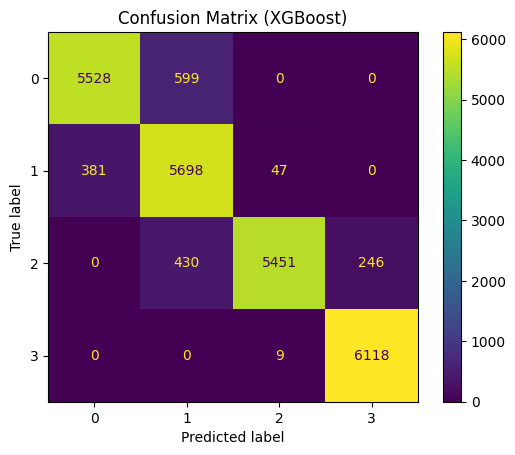

In [48]:
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

In [49]:
def rekomendasi_makanan(child_row, menu_df, model, feature_columns, filter_by_label=False):
    umur = child_row["Umur (bulan)"]

    if umur <= 5:
        return [{
            "menu": "ASI Eksklusif ",
            "label_prediksi": "Rekomendasi utama",
            "frekuensi": "Sesuai kebutuhan bayi",
            "nutrisi": {"Keterangan": "ASI eksklusif sudah mencukupi gizi bayi <6 bulan"}
        }, {
            "menu": "Susu Formula",
            "label_prediksi": "Alternatif jika ASI tidak tersedia",
            "frekuensi": "Sesuai dosis kemasan",
            "nutrisi": {"Keterangan": "Pastikan susu formula sesuai anjuran dokter"}
        }]

    frekuensi_map = {
        "F1": "2 kali makanan utama per hari",
        "F2": "3 kali makanan utama per hari",
        "F3": "3x makanan utama + 1x snack per hari",
        "F4": "3x makanan utama + 2x snack per hari"
    }
    gizi_map = {
        0: "Sangat Pendek – Risiko tinggi stunting",
        1: "Pendek – Perlu perhatian gizi",
        2: "Normal – Pertumbuhan baik",
        3: "Tinggi – Di atas rata-rata"
    }

    rekomendasi = []
    target_label = int(child_row.get("label_gizi", 2))  # default: Normal

    for _, menu in menu_df.iterrows():
        row = {
            "child_id": child_row["child_id"],
            "Umur (bulan)": umur,
            "Tinggi Badan (cm)": child_row["Tinggi Badan (cm)"],
            "menu_id": menu["menu_id"]
        }

        # Tambahkan fitur nutrisi dari menu
        for col in feature_columns:
            if col not in row and col in menu:
                row[col] = menu[col]

        row_df = pd.DataFrame([row])[feature_columns].fillna(0)

        try:
            pred = int(model.predict(row_df).reshape(-1)[0])
        except:
            pred = -1  # jika error prediksi

        # Bisa diaktifkan/disable filter by label_gizi
        if filter_by_label and pred != target_label:
            continue

        nutrisi = {
            "kalori (kkal)": round(menu.get("calories_kcal", 0), 2),
            "protein (g)": round(menu.get("protein_g", 0), 2),
            "karbohidrat (g)": round(menu.get("carb_g", 0), 2),
            "lemak (g)": round(menu.get("fats_g", 0), 2),
            "zat besi (mg)": round(menu.get("zinc_mg", 0), 2),
            "vitamin A (g)": round(menu.get("vitA_g", 0), 2)
        }

        kode_frek = menu.get("Kode Frekuensi", "F2")
        deskripsi_frek = frekuensi_map.get(kode_frek, "Frekuensi tidak diketahui")
        deskripsi_gizi = gizi_map.get(pred, "Tidak diketahui")

        rekomendasi.append({
            "menu": menu.get("Kombinasi Menu", f"Menu {menu['menu_id']}"),
            "label_prediksi": deskripsi_gizi,
            "frekuensi": deskripsi_frek,
            "nutrisi": nutrisi
        })

    # Fallback jika kosong
    if not rekomendasi:
        fallback = menu_df.sample(5)
        for _, menu in fallback.iterrows():
            rekomendasi.append({
                "menu": menu.get("Kombinasi Menu", f"Menu {menu['menu_id']}"),
                "label_prediksi": "Alternatif (fallback)",
                "frekuensi": frekuensi_map.get(menu.get("Kode Frekuensi", "F2"), "Tidak diketahui"),
                "nutrisi": {
                    "kalori (kkal)": round(menu.get("calories_kcal", 0), 2),
                    "protein (g)": round(menu.get("protein_g", 0), 2),
                    "karbohidrat (g)": round(menu.get("carb_g", 0), 2),
                    "lemak (g)": round(menu.get("fats_g", 0), 2),
                    "zat besi (mg)": round(menu.get("zinc_mg", 0), 2),
                    "vitamin A (g)": round(menu.get("vitA_g", 0), 2)
                }
            })

    return rekomendasi[:5]


In [56]:
# Ambil anak tertentu dari dataset merged
# INPUTAN LANGSUNG
umur_input = 10 # contoh umur dalam bulan
tinggi_input = 85  # contoh tinggi badan dalam cm

# Buat data anak dalam format pd.Series
anak = pd.Series({
    "child_id": 999,  # dummy ID
    "Umur (bulan)": umur_input,
    "Tinggi Badan (cm)": tinggi_input,
    "label_gizi": 2
})

# Nutrisi columns dari fitur
nutrisi_cols = features[4:]

# Load data menu
menu_df = pd.read_csv("/content/data_menu_mpasi.csv")
menu_df.rename(columns={"Kode Menu": "menu_id"}, inplace=True)
menu_df['menu_id'] = pd.factorize(menu_df['menu_id'])[0].astype(int)
menu_df = menu_df[['menu_id', 'Kombinasi Menu', 'Kode Frekuensi'] + nutrisi_cols]

# --- Tambahkan prediksi status gizi anak sebelum rekomendasi menu ---
fitur_input = pd.DataFrame([{
    "child_id": anak["child_id"],
    "Umur (bulan)": anak["Umur (bulan)"],
    "Tinggi Badan (cm)": anak["Tinggi Badan (cm)"],
    "menu_id": 0  # dummy menu
}], columns=features).fillna(0)

pred_gizi = int(model.predict(fitur_input).reshape(-1)[0])

gizi_map = {
    0: "Sangat Pendek – Risiko tinggi stunting",
    1: "Pendek – Perlu perhatian gizi",
    2: "Normal – Pertumbuhan baik",
    3: "Tinggi – Di atas rata-rata"
}

print(f"\nPrediksi Status Gizi Anak : {gizi_map.get(pred_gizi, 'Tidak diketahui')}\n")

# --- Rekomendasi menu berdasarkan prediksi ---
hasil_rekomendasi = rekomendasi_makanan(anak, menu_df, model, features, filter_by_label=True)

# --- Konversi hasil ke DataFrame ---
rows = []
for item in hasil_rekomendasi:
    row = {
        "Menu": item["menu"],
        "Frekuensi": item["frekuensi"]
    }
    row.update(item["nutrisi"])
    rows.append(row)

df_hasil = pd.DataFrame(rows)

# Tampilkan semua kolom
pd.set_option('display.max_columns', None)
df_hasil



Prediksi Status Gizi Anak : Tinggi – Di atas rata-rata



Menu  \
0        Roti gandum, telur, keju, pisang   
1  Nasi, ayam goreng, tumis bayam, pepaya   
2         Nasi tim halus, ikan, labu siam   
3           Bubur singkong, telur, wortel   
4            Nasi, tahu, capcay, semangka   

                              Frekuensi  kalori (kkal)  protein (g)  \
0  3x makanan utama + 2x snack per hari          270.0         11.0   
1  3x makanan utama + 2x snack per hari          270.0         11.0   
2         2 kali makanan utama per hari          180.0          7.5   
3         2 kali makanan utama per hari          180.0          7.5   
4  3x makanan utama + 1x snack per hari          250.0         10.0   

   karbohidrat (g)  lemak (g)  zat besi (mg)  vitamin A (g)  
0             38.0       10.0            1.7           0.22  
1             38.0       10.0            1.7           0.22  
2             25.0        6.0            1.0           0.14  
3             25.0        6.0            1.0           0.14  
4             35.0        9.0            1.5           0.20

Berdasarkan output diatas, sistem berhasil merekomendasikan beberapa kombinasi menu teratas untuk anak tertentu dengan menggunakan model XGBoost. Model ini tidak hanya memfilter makanan berdasarkan nutrisi, tapi juga memperkirakan dampaknya terhadap status gizi. Hasil akhirnya adalah daftar makanan MPASI yang paling cocok dan bermanfaat untuk meningkatkan atau mempertahankan status gizi anak, disesuaikan dengan usia, tinggi badan, dan kombinasi makanan lainnya.

# **Pipeline Content-Based Filtering**

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

nutrient_cols = ['calories_kcal', 'fats_g', 'sod_mg', 'carb_g', 'fiber_g', 'sugar_g',
                 'protein_g', 'vitA_g', 'calcium_mg', 'thiamin_mg', 'zinc_mg',
                 'potassium_mg', 'magnesium_mg', 'vitE_mg', 'vitK_mcg', 'vitC_mg',
                 'vitB6_mg', 'copper_mg', 'carotene_mg', 'carotene_mcg',
                 'cryptoxanthin_mcg', 'lycopene_mcg', 'cholesterol_mg']

# Ambil fitur nutrisi dari menu MPASI
menu_features = food_data[nutrient_cols]

# Hitung similarity antar menu
content_sim = cosine_similarity(menu_features)

# Fungsi rekomendasi berdasarkan item (menu) yang mirip
def recommend_similar_menus(kode_menu, top_n=5):
    idx = food_data[food_data['Kode Menu'] == kode_menu].index[0]
    sim_scores = list(enumerate(content_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return food_data.iloc[[i[0] for i in sim_scores]][['Kode Menu', 'Kombinasi Menu']]

In [52]:
# Gunakan fungsi recommend_similar_menus untuk mendapatkan rekomendasi berdasarkan kode menu
recommend_similar_menus("M122")

Kode Menu                         Kombinasi Menu
102      M113         Nasi, ikan, sayur lodeh, jeruk
103      M114       Spaghetti, daging, tomat, pisang
104      M115    Kentang, telur dadar, brokoli, apel
105      M116  Nasi merah, tempe, sop ayam, semangka
106      M117    Roti, telur orak-arik, tomat, jeruk

In [53]:
# Gunakan fungsi recommend_similar_menus untuk mendapatkan rekomendasi berdasarkan kode menu
recommend_similar_menus("M11")

Kode Menu                    Kombinasi Menu
1       M12  Bubur kentang, hati ayam, wortel
2       M13   Nasi tim halus, ikan, labu siam
3       M14  Bubur beras merah, tahu, brokoli
4       M15        Bubur kacang hijau, pisang
5       M16  Pure kentang, daging ayam, bayam

Berdasarkan output diatas, sistem berhasil merekomendasikan 5 kombinasi menu teratas yang memiliki menu makanan yang paling mirip dengan kode menu 'M11'.

In [54]:
# simpan model untuk format .json
import json
model.save_model("xgboost_model.json")

In [55]:
# simpan model untuk format .pkl (pickle)
import pickle

with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(model, f)
